In [47]:
# Importing the necessary libraries

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

import statsmodels.api as sm

In [48]:
# Global Settings
pd.set_option("display.float_format", lambda x: "%.4f" % x)

In [49]:
# Importing Configs
# Define the path where config.py is located
# Mac
os.chdir("/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling")
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config

# Configs
finbert_models = config.finbert_models
Body = config.Body
database = config.Local_Database

/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [50]:
sentiment = pd.date_range(start="1/1/1990", end="1/1/2024", freq="D")
sentiment = pd.DataFrame(sentiment, columns=["date"])

Body = "Fed"

state = pd.read_csv(
    f"{finbert_models}/{Body}/Statements/{Body}_Statements_finbert_model_short.csv"
)
state = state[["date", "sentiment"]]
state = state.rename(columns={"sentiment": "statement_sentiment"})
state["date"] = pd.to_datetime(state["date"])
sentiment = pd.merge(sentiment, state, how="left", left_on="date", right_on="date")

In [51]:
minutes = pd.read_csv(
    f"{finbert_models}/{Body}/Minutes/{Body}_Minutes_finbert_model_short.csv"
)
minutes = minutes[["date", "sentiment"]]
minutes = minutes.rename(columns={"sentiment": "minute_sentiment"})
minutes["date"] = pd.to_datetime(minutes["date"])

minutes = minutes.groupby("date").mean().reset_index()

filter_df = minutes.copy(deep=True)
filter_df = filter_df[["date", "minute_sentiment"]]

cycle, trend = sm.tsa.filters.hpfilter(
    filter_df["minute_sentiment"], 1600 * ((8 / 4) ** 4)
)

filter_df["minute_sentiment_cycle"] = cycle
filter_df["minute_sentiment_trend"] = trend

filter_df = filter_df[["date", "minute_sentiment_cycle"]]
minutes = minutes.drop(columns=["minute_sentiment"])
filter_df = filter_df.rename(columns={"minute_sentiment_cycle": "minute_sentiment"})
minutes = pd.merge(minutes, filter_df, on="date", how="left")
minutes = minutes.groupby("date").mean().reset_index()

sentiment = pd.merge(sentiment, minutes, how="left", left_on="date", right_on="date")

In [52]:
Body = "ECB"
pc = pd.read_csv(
    f"{finbert_models}/{Body}/Press Conferences/{Body}_Press Conferences_finbert_model_short.csv"
)
pc = pc[["date", "sentiment"]]
pc = pc.rename(columns={"sentiment": "pc_sentiment"})

pc["date"] = pd.to_datetime(pc["date"])

pc = pc.groupby("date").mean().reset_index()

filter_df = pc.copy(deep=True)
filter_df = filter_df[["date", "pc_sentiment"]]

cycle, trend = sm.tsa.filters.hpfilter(filter_df["pc_sentiment"], 100 * (8**2))

filter_df["pc_sentiment_cycle"] = cycle
filter_df["pc_sentiment_trend"] = trend

filter_df = filter_df[["date", "pc_sentiment_cycle"]]
pc = pc.drop(columns=["pc_sentiment"])
filter_df = filter_df.rename(columns={"pc_sentiment_cycle": "pc_sentiment"})
pc = pd.merge(pc, filter_df, on="date", how="left")
pc = pc.groupby("date").mean().reset_index()

sentiment = pd.merge(sentiment, pc, how="left", left_on="date", right_on="date")

In [53]:
sentiment = sentiment.groupby(pd.Grouper(key="date", freq="D")).mean().reset_index()

In [54]:
minutes = minutes.groupby("date").mean().reset_index()
minutes["count"] = range(len(minutes))
minutes = minutes[["date", "count"]]
sentiment = pd.merge(sentiment, minutes, how="left", left_on="date", right_on="date")
sentiment["count"] = sentiment["count"].ffill()

In [55]:
sent_temp = sentiment.copy(deep=True)
# Forward fill all na values for sentiment

sent_temp["statement_sentiment"] = sent_temp["statement_sentiment"].fillna(
    method="ffill"
)

sent_temp["diff_fed_sentiment"] = (
    sent_temp["minute_sentiment"] - sent_temp["statement_sentiment"]
)

# drop all rows where minute_sentiment is na
sent_temp = sent_temp.dropna(subset=["minute_sentiment"])

sent_temp = sent_temp[["date", "diff_fed_sentiment"]]

sentiment = pd.merge(sentiment, sent_temp, how="left", left_on="date", right_on="date")

In [56]:
mich = pd.read_csv(f"{database}/Market Data/Michigan/michigan_sent.csv")
# convert Month from a string to a number
mich["Month"] = mich["Month"].str.replace("January", "01")
mich["Month"] = mich["Month"].str.replace("February", "02")
mich["Month"] = mich["Month"].str.replace("March", "03")
mich["Month"] = mich["Month"].str.replace("April", "04")
mich["Month"] = mich["Month"].str.replace("May", "05")
mich["Month"] = mich["Month"].str.replace("June", "06")
mich["Month"] = mich["Month"].str.replace("July", "07")
mich["Month"] = mich["Month"].str.replace("August", "08")
mich["Month"] = mich["Month"].str.replace("September", "09")
mich["Month"] = mich["Month"].str.replace("October", "10")
mich["Month"] = mich["Month"].str.replace("November", "11")
mich["Month"] = mich["Month"].str.replace("December", "12")

# combine Month and YYYY columns and convert to datetime
mich["date"] = mich["Month"].astype(str) + "-" + mich["YYYY"].astype(str)
mich["date"] = pd.to_datetime(mich["date"])
mich = mich[["date", "ICS_ALL"]]
mich = mich.rename(columns={"ICS_ALL": "michigan_sentiment"})

sentiment = pd.merge(sentiment, mich, how="outer", left_on="date", right_on="date")

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_50782/598583073.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mich["date"] = pd.to_datetime(mich["date"])


In [57]:
market = pd.read_csv(f"{database}/Market Data/All Market Data.csv")
market = market.rename(columns={"PCE": "pce", "GDP": "gdp", "GDPPOT": "gdp_pot"})
market["date"] = pd.to_datetime(market["date"])

In [58]:
taylor = pd.read_csv(
    f"/Users/kylenabors/Documents/Database/Market Data/Taylor/Taylor.csv"
)
taylor["date"] = pd.to_datetime(taylor["date"])
taylor = taylor.rename(columns={"Taylor": "taylor_fred"})

In [59]:
sentiment = pd.merge(sentiment, market, how="left", left_on="date", right_on="date")
# sentiment = pd.merge(sentiment, taylor, how='left', left_on='date', right_on='date'

In [60]:
temp = sentiment.copy(deep=True)
temp = temp[["count", "sp500_return"]]
temp["log_returns"] = np.log(temp["sp500_return"] + 1)
temp = temp[["count", "log_returns"]]
temp = temp.groupby("count").sum().reset_index()
sentiment = sentiment.groupby(sentiment["count"]).mean().reset_index()

sentiment = pd.merge(sentiment, temp, how="left", left_on="count", right_on="count")

sentiment = sentiment.drop(columns=["date"])
minutes = minutes[["date", "count"]]
sentiment = pd.merge(sentiment, minutes, how="left", left_on="count", right_on="count")
sentiment["date"] = pd.to_datetime(sentiment["date"])
sentiment["minute_sentiment_diff"] = sentiment["minute_sentiment"].diff()

In [61]:
sentiment["michigan_sentiment_norm"] = (
    sentiment["michigan_sentiment"] - sentiment["michigan_sentiment"].mean()
) / (sentiment["michigan_sentiment"].max() - sentiment["michigan_sentiment"].min())
sentiment["minute_sentiment_norm"] = (
    sentiment["minute_sentiment"] - sentiment["minute_sentiment"].mean()
) / (sentiment["minute_sentiment"].max() - sentiment["minute_sentiment"].min())

# Createa a new column that is a dummy variable for minute sentiment being greater than michigan sentiment
sentiment["minute_sentiment_dummy"] = np.where(
    sentiment["minute_sentiment_norm"] > sentiment["minute_sentiment_norm"].shift(-1),
    1,
    0,
)

In [62]:
sentiment["gap"] = (sentiment["gdp"] - sentiment["gdp_pot"]) / sentiment["gdp_pot"]
sentiment["gap"] = sentiment["gap"] * 100

In [63]:
sentiment["taylor"] = (
    2 + sentiment["gdpdef"] + 0.5 * (sentiment["gdpdef"] - 2) + 0.5 * (sentiment["gap"])
)

In [64]:
# caculate moving average of minute sentiment
rolling = 8
sentiment["minute_sentiment_rolling"] = (
    sentiment["minute_sentiment"].rolling(window=rolling).mean()
)
sentiment["log_returns_rolling"] = (
    sentiment["log_returns"].rolling(window=rolling).mean()
)
sentiment["michigan_sentiment_rolling"] = (
    sentiment["michigan_sentiment"].rolling(window=rolling).mean()
)
sentiment["minute_sentiment_diff_rolling"] = (
    sentiment["minute_sentiment_diff"].rolling(window=rolling).mean()
)

In [65]:
sentiment_groups = [
    "minute_sentiment",
    "minute_sentiment_diff",
    "minute_sentiment_rolling",
    "minute_sentiment_diff_rolling",
    "log_returns",
    "log_returns_rolling",
]
for group in sentiment_groups:
    for i in range(0, 8):
        sentiment[f"{group}_{i}"] = sentiment[f"{group}"].shift(i)
        # sentiment[f'{group}_{i}'] =  sentiment[f'{group}_{i}'].diff()
        # sentiment[f'{group}_sentiment_forward_{i}'] = sentiment[f'{group}_sentiment'].shift(-i)

market_groups = ["fedfunds", "log_returns"]

for group in market_groups:
    for i in range(0, 8):
        sentiment[f"{group}_{i}"] = sentiment[f"{group}"].shift(i)
        # sentiment[f'{group}_forward_{i}'] = sentiment[f'{group}'].shift(-i)

In [66]:
sentiment = sentiment[
    (sentiment["date"] >= "2000-01-01") & (sentiment["date"] <= "2023-01-01")
]

sentiment.to_csv(
    f"/Users/kylenabors/Documents/Database/Models/FinBERT Models/taylor MBreak.csv",
    index=False,
)

In [67]:
# #create a list of all the columns in the dataframe sentiment
# columns = sentiment.columns


# #loop through the columns and normalize the data
# for column in columns:
#     if column != 'date':
#         sentiment[column] = (sentiment[column] - sentiment[column].mean()) / (sentiment[column].max() - sentiment[column].min())

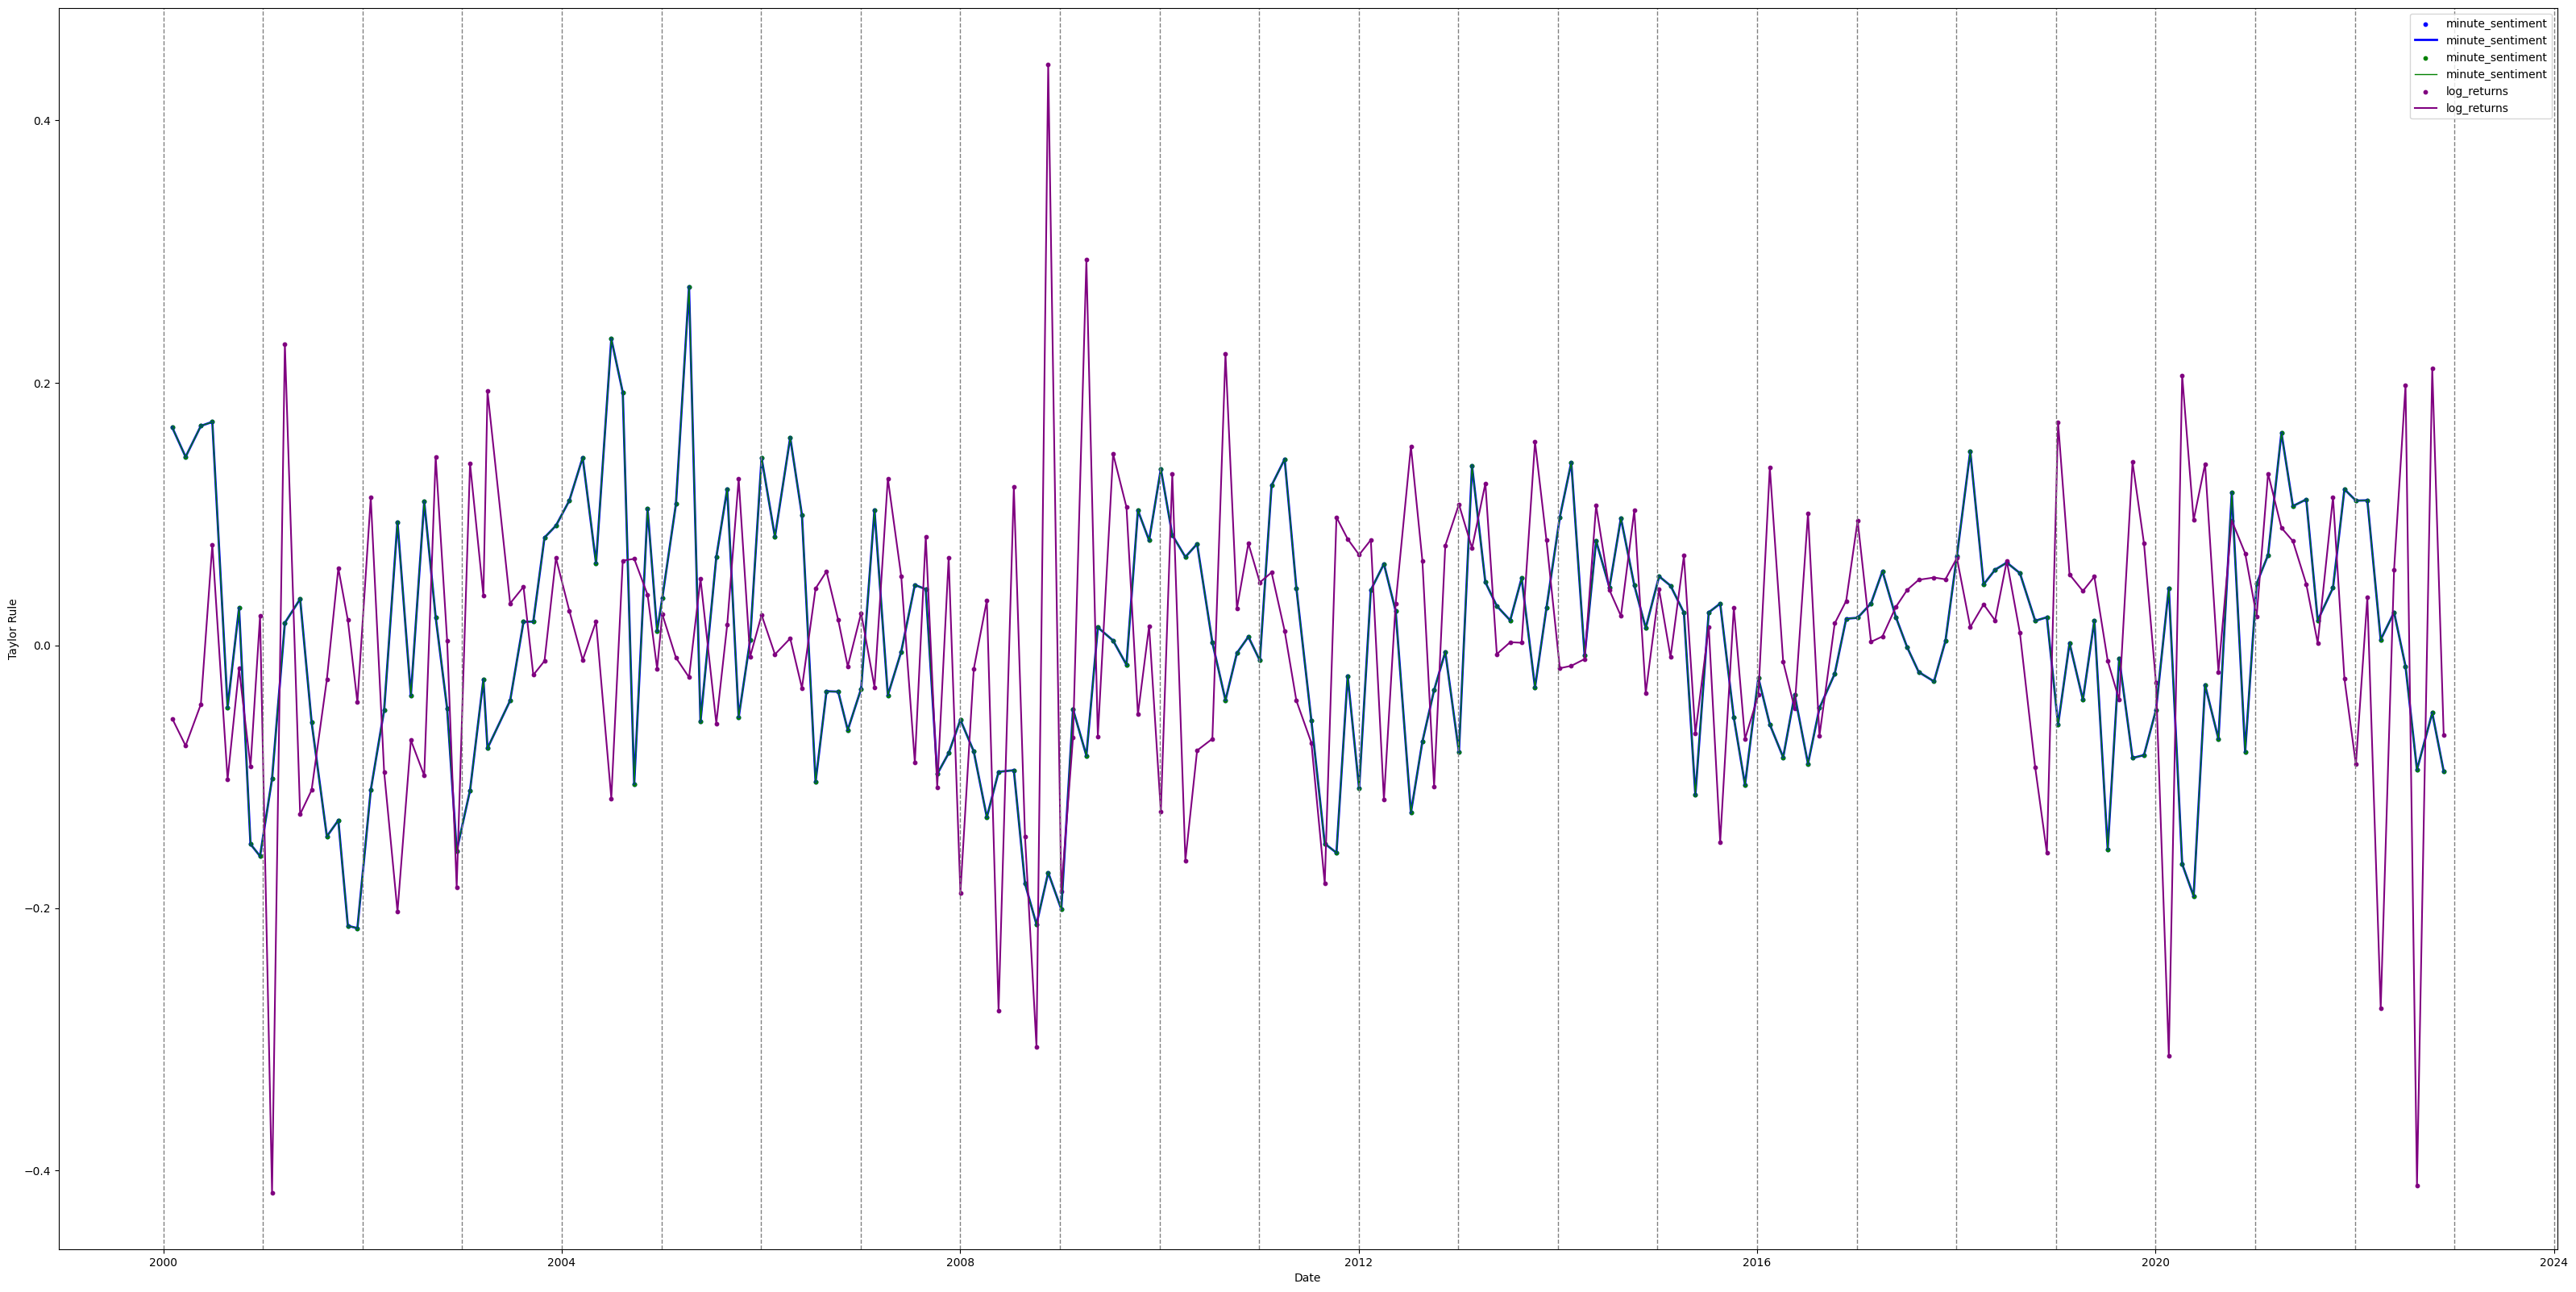

In [68]:
x1 = "minute_sentiment"
x2 = "minute_sentiment"
x3 = "log_returns"
x4 = "log_returns"

# Graph the Data
fig, ax = plt.subplots(figsize=(40, 20))

ax.scatter(sentiment["date"], sentiment[f"{x1}"], label=f"{x1}", color="blue", s=10)
ax.plot(sentiment["date"], sentiment[f"{x1}"], label=f"{x1}", color="blue", lw=2)

ax.scatter(sentiment["date"], sentiment[f"{x2}"], label=f"{x2}", color="green", s=10)
ax.plot(sentiment["date"], sentiment[f"{x2}"], label=f"{x2}", color="green", lw=1)

# ax.scatter(sentiment['date'], sentiment[f'{x3}'], label=f'{x3}', color='red', s=10)
# ax.plot(sentiment['date'], sentiment[f'{x3}'], label=f'{x3}', color='red', lw = 2)

ax.scatter(sentiment["date"], sentiment[f"{x4}"], label=f"{x4}", color="purple", s=10)
ax.plot(sentiment["date"], sentiment[f"{x4}"], label=f"{x4}", color="purple")

# ax.scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black', s=10)
# ax.plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')

# ax.scatter(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='black', s=10)
# ax.plot(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='grey')

# Create a vertical line at every year
for year in range(2000, 2025):
    ax.axvline(pd.to_datetime(f"{year}-01-01"), color="gray", linestyle="--", lw=1)

ax.set_xlabel("Date")
ax.set_ylabel("Taylor Rule")
ax.legend()
plt.show()

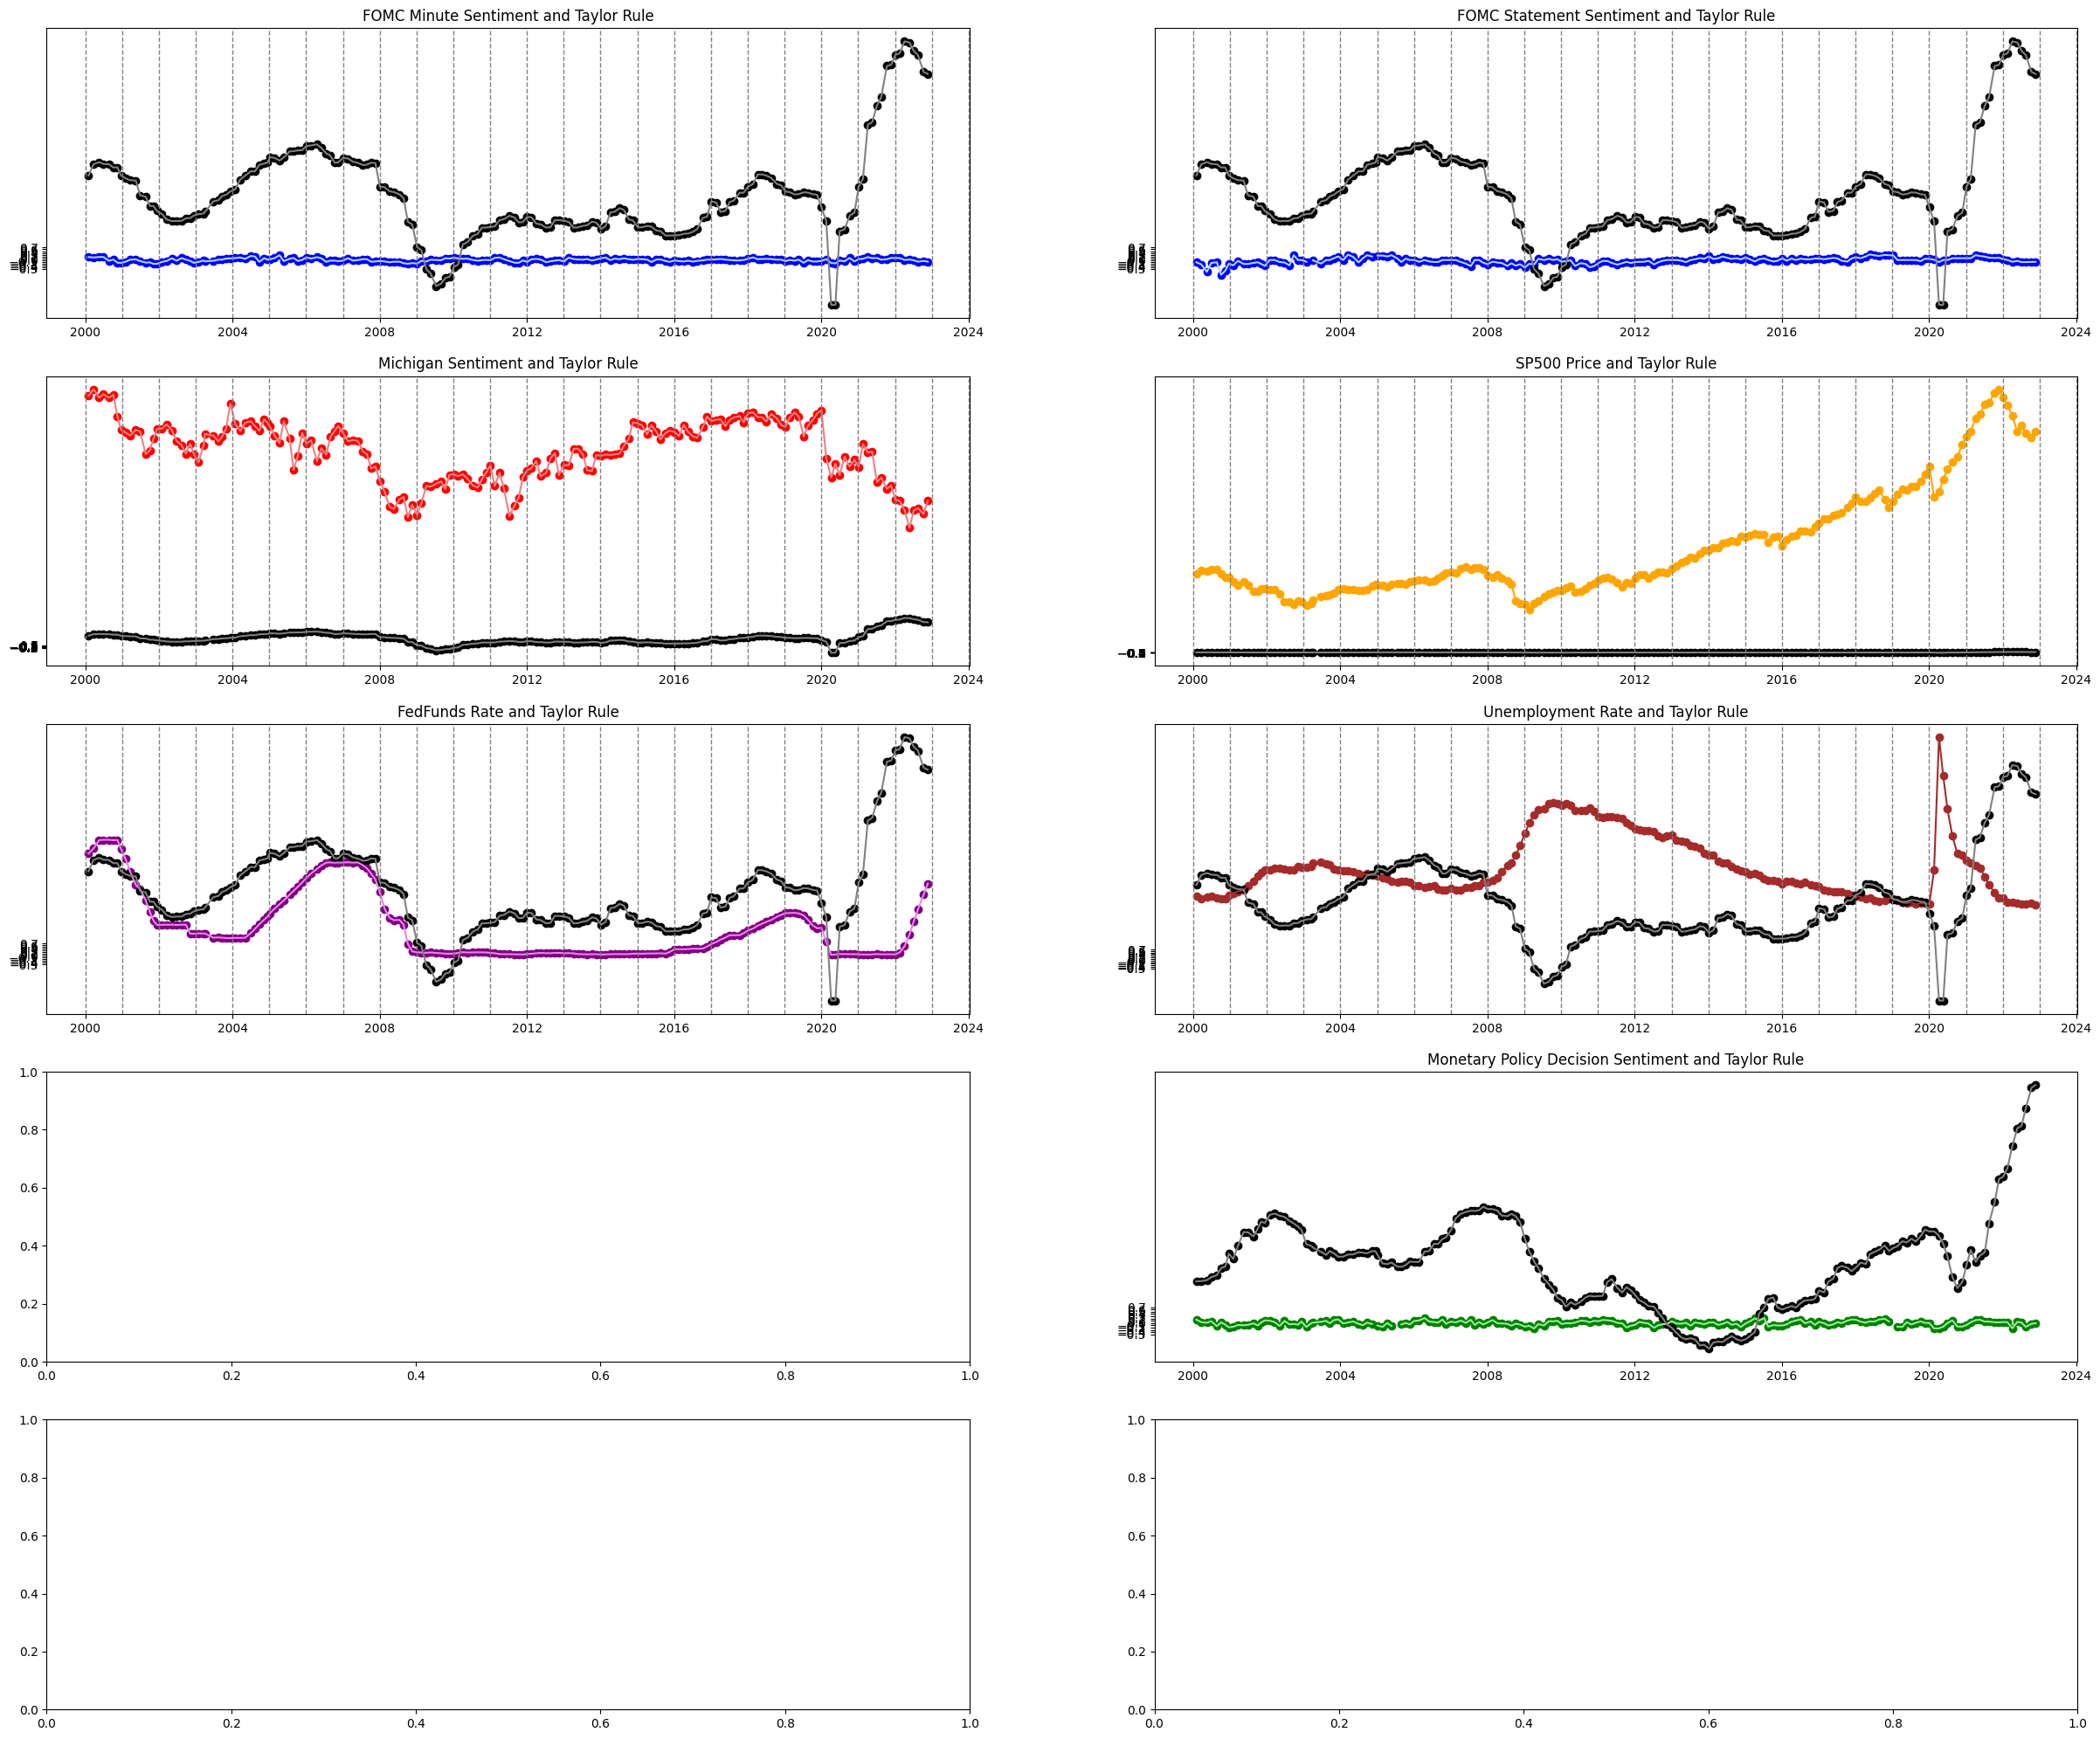

In [69]:
# recreate the previous graph but using multiple subplots where every subplot is a different variable compared to the Taylor Rule
fig, ax = plt.subplots(5, 2, figsize=(30, 25))

ax[0, 0].scatter(
    sentiment["date"],
    sentiment["minute_sentiment"],
    label="FOMC Minute Sentiment",
    color="blue",
)
ax[0, 0].plot(
    sentiment["date"],
    sentiment["minute_sentiment"],
    label="FOMC Minute Sentiment",
    color="lightblue",
)
ax[0, 0].scatter(
    sentiment["date"], sentiment["taylor"], label="Taylor Rule", color="black"
)
ax[0, 0].plot(sentiment["date"], sentiment["taylor"], label="Taylor Rule", color="grey")
ax[0, 0].set_title("FOMC Minute Sentiment and Taylor Rule")
ax[0, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[0, 1].scatter(
    sentiment["date"],
    sentiment["statement_sentiment"],
    label="Statement Sentiment",
    color="blue",
)
ax[0, 1].plot(
    sentiment["date"],
    sentiment["statement_sentiment"],
    label="Statement Sentiment",
    color="lightblue",
)
ax[0, 1].scatter(
    sentiment["date"], sentiment["taylor"], label="Taylor Rule", color="black"
)
ax[0, 1].plot(sentiment["date"], sentiment["taylor"], label="Taylor Rule", color="grey")
ax[0, 1].set_title("FOMC Statement Sentiment and Taylor Rule")
ax[0, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[1, 0].scatter(
    sentiment["date"],
    sentiment["michigan_sentiment"],
    label="Michigan Sentiment",
    color="red",
)
ax[1, 0].plot(
    sentiment["date"],
    sentiment["michigan_sentiment"],
    label="Michigan Sentiment",
    color="lightcoral",
)
ax[1, 0].scatter(
    sentiment["date"], sentiment["taylor"], label="Taylor Rule", color="black"
)
ax[1, 0].plot(sentiment["date"], sentiment["taylor"], label="Taylor Rule", color="grey")
ax[1, 0].set_title("Michigan Sentiment and Taylor Rule")
ax[1, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[1, 1].scatter(
    sentiment["date"], sentiment["sp500_price"], label="SP500 Price", color="orange"
)
ax[1, 1].plot(
    sentiment["date"], sentiment["sp500_price"], label="SP500 Price", color="orange"
)
ax[1, 1].scatter(
    sentiment["date"], sentiment["taylor"], label="Taylor Rule", color="black"
)
ax[1, 1].plot(sentiment["date"], sentiment["taylor"], label="Taylor Rule", color="grey")
ax[1, 1].set_title("SP500 Price and Taylor Rule")
ax[1, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[2, 0].scatter(
    sentiment["date"], sentiment["fedfunds"], label="FedFunds Rate", color="purple"
)
ax[2, 0].plot(
    sentiment["date"], sentiment["fedfunds"], label="FedFunds Rate", color="violet"
)
ax[2, 0].scatter(
    sentiment["date"], sentiment["taylor"], label="Taylor Rule", color="black"
)
ax[2, 0].plot(sentiment["date"], sentiment["taylor"], label="Taylor Rule", color="grey")
ax[2, 0].set_title("FedFunds Rate and Taylor Rule")
ax[2, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[2, 1].scatter(
    sentiment["date"],
    sentiment["unemployment"],
    label="Unemployment Rate",
    color="brown",
)
ax[2, 1].plot(
    sentiment["date"],
    sentiment["unemployment"],
    label="Unemployment Rate",
    color="brown",
)
ax[2, 1].scatter(
    sentiment["date"], sentiment["taylor"], label="Taylor Rule", color="black"
)
ax[2, 1].plot(sentiment["date"], sentiment["taylor"], label="Taylor Rule", color="grey")
ax[2, 1].set_title("Unemployment Rate and Taylor Rule")
ax[2, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))


ax[3, 1].scatter(
    sentiment["date"],
    sentiment["pc_sentiment"],
    label="Monetary Policy Decision Sentiment",
    color="green",
)
ax[3, 1].plot(
    sentiment["date"],
    sentiment["pc_sentiment"],
    label="Monetary Policy Decision Sentiment",
    color="lightgreen",
)
ax[3, 1].scatter(
    sentiment["date"],
    sentiment["taylor_euro"],
    label="Taylor Rule Europe",
    color="black",
)
ax[3, 1].plot(
    sentiment["date"],
    sentiment["taylor_euro"],
    label="Taylor Rule Europe",
    color="grey",
)
ax[3, 1].set_title("Monetary Policy Decision Sentiment and Taylor Rule")
ax[3, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))


# Create a vertical line at every year
for i in range(3):
    for j in range(2):
        for year in range(2000, 2025):
            ax[i, j].axvline(
                pd.to_datetime(f"{year}-01-01"), color="gray", linestyle="--", lw=1
            )

plt.show()